In [4]:
# ====== 1. IMPORTS & SETTINGS ======
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths & file names
DATA_FILE = "netflix1.csv"  # Your dataset
FIG_DIR = "./figs"
OUT_DIR = "./output"

# Create folders for outputs
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# ====== 2. LOAD DATA ======
df = pd.read_csv(DATA_FILE)

# Overview
print("Shape:", df.shape)
print("\nFirst 5 rows:\n", df.head())
print("\nMissing values:\n", df.isna().sum())
print("\nDuplicates:", df.duplicated().sum())


Shape: (8790, 10)

First 5 rows:
   show_id     type                             title         director  \
0      s1    Movie              Dick Johnson Is Dead  Kirsten Johnson   
1      s3  TV Show                         Ganglands  Julien Leclercq   
2      s6  TV Show                     Midnight Mass    Mike Flanagan   
3     s14    Movie  Confessions of an Invisible Girl    Bruno Garotti   
4      s8    Movie                           Sankofa     Haile Gerima   

         country date_added  release_year rating  duration  \
0  United States  9/25/2021          2020  PG-13    90 min   
1         France  9/24/2021          2021  TV-MA  1 Season   
2  United States  9/24/2021          2021  TV-MA  1 Season   
3         Brazil  9/22/2021          2021  TV-PG    91 min   
4  United States  9/24/2021          1993  TV-MA   125 min   

                                           listed_in  
0                                      Documentaries  
1  Crime TV Shows, International TV Shows, T

In [5]:
# ====== 3. CLEANING ======
# Remove duplicates
df.drop_duplicates(inplace=True)

# Convert date_added to datetime
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# Strip spaces from text columns
text_cols = ['type', 'title', 'director', 'country', 'rating', 'duration', 'listed_in']
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype('string').str.strip()

# Fill nulls in important columns
df['director'] = df['director'].fillna('Not Given')
df['country'] = df['country'].fillna('Not Given')

# Extract year/month/day
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month
df['day_added'] = df['date_added'].dt.day

# Split genres into list
df['genres'] = df['listed_in'].fillna('Not Given').str.split(', ')

# Parse duration into minutes/seasons
def parse_duration(val):
    if pd.isna(val):
        return (np.nan, np.nan)
    s = str(val).lower()
    if "min" in s:
        try:
            mins = float(s.split(" ")[0])
        except:
            mins = np.nan
        return (mins, np.nan)
    if "season" in s:
        try:
            seasons = float(s.split(" ")[0])
        except:
            seasons = np.nan
        return (np.nan, seasons)
    return (np.nan, np.nan)

parsed = df['duration'].apply(parse_duration)
df['duration_minutes'] = parsed.apply(lambda x: x[0])
df['seasons'] = parsed.apply(lambda x: x[1])

# Check cleaned data
df.head()


,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in,year_added,month_added,day_added,genres,duration_minutes,seasons
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,2021-09-25,2020,PG-13,90 min,Documentaries,2021,9,25,[Documentaries],90.0,NaN
1,s3,TV Show,Ganglands,Julien Leclercq,France,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",2021,9,24,"[Crime TV Shows, International TV Shows, TV Ac...",NaN,1.0
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,2021-09-24,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries",2021,9,24,"[TV Dramas, TV Horror, TV Mysteries]",NaN,1.0
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,2021-09-22,2021,TV-PG,91 min,"Children & Family Movies, Comedies",2021,9,22,"[Children & Family Movies, Comedies]",91.0,NaN
4,s8,Movie,Sankofa,Haile Gerima,United States,2021-09-24,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies",2021,9,24,"[Dramas, Independent Movies, International Mov...",125.0,NaN


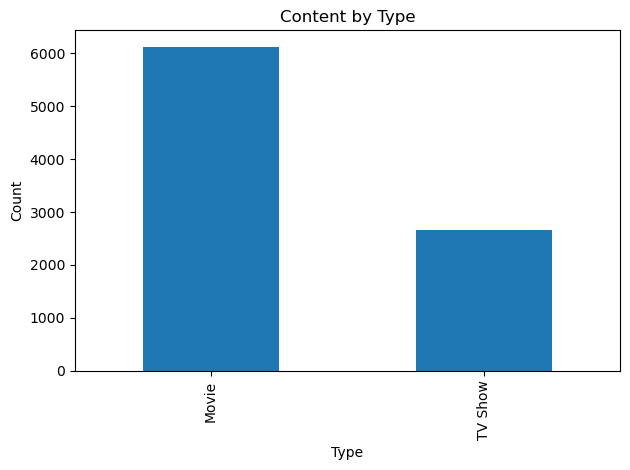

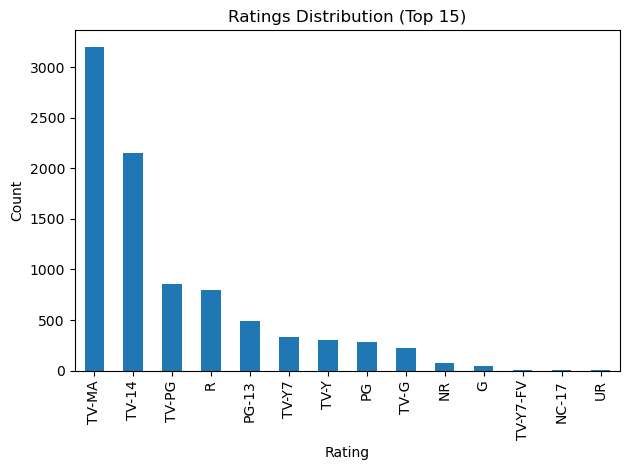

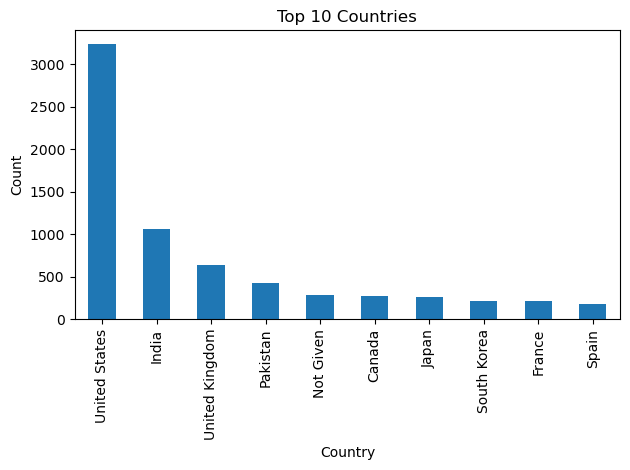

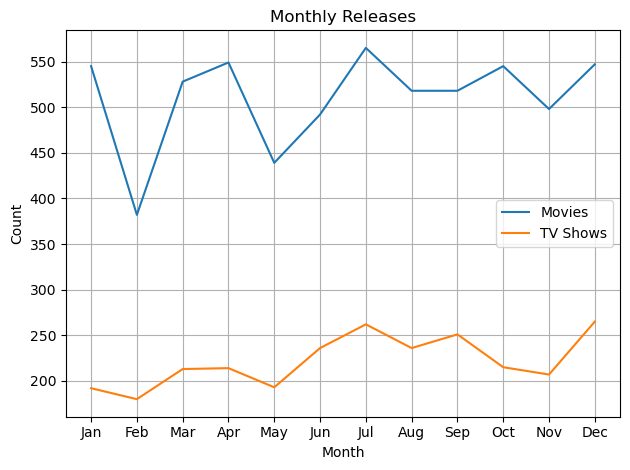

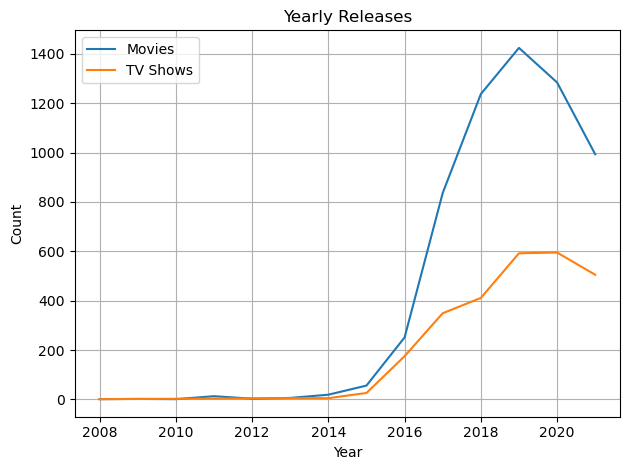

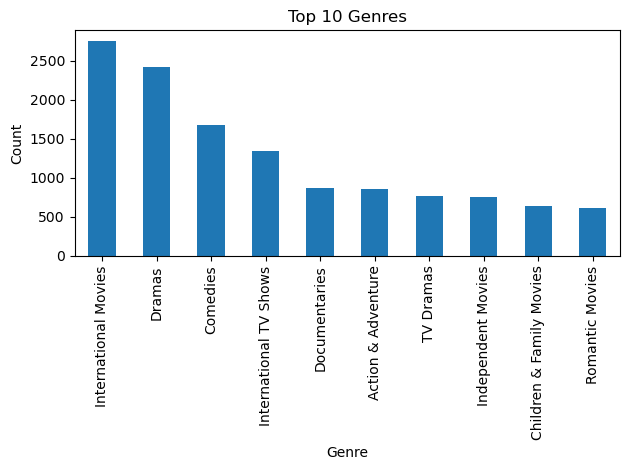

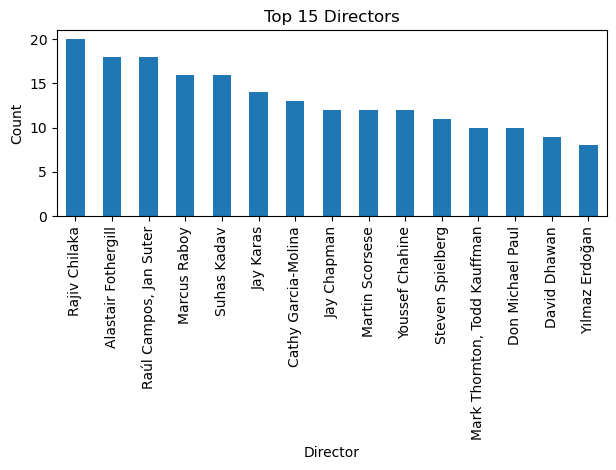

Figures saved in: ./figs


In [6]:
# ====== 4. PLOTTING ======
def savefig(name):
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, name), dpi=200)  # Save first
    plt.show()  # Then show

# 1. Content by Type
df['type'].value_counts().plot(kind='bar', title='Content by Type')
plt.xlabel('Type'); plt.ylabel('Count')
savefig('content_by_type.png')

# 2. Ratings distribution
df['rating'].value_counts().head(15).plot(kind='bar', title='Ratings Distribution (Top 15)')
plt.xlabel('Rating'); plt.ylabel('Count')
savefig('ratings_distribution.png')

# 3. Top 10 Countries
df['country'].value_counts().head(10).plot(kind='bar', title='Top 10 Countries')
plt.xlabel('Country'); plt.ylabel('Count')
savefig('top_10_countries.png')

# 4. Monthly releases
monthly_movie = df[df['type'] == 'Movie']['month_added'].value_counts().sort_index()
monthly_show = df[df['type'] == 'TV Show']['month_added'].value_counts().sort_index()
plt.plot(monthly_movie.index, monthly_movie.values, label='Movies')
plt.plot(monthly_show.index, monthly_show.values, label='TV Shows')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Month'); plt.ylabel('Count')
plt.title('Monthly Releases'); plt.legend(); plt.grid(True)
savefig('monthly_releases.png')

# 5. Yearly releases
yearly_movie = df[df['type'] == 'Movie']['year_added'].value_counts().sort_index()
yearly_show = df[df['type'] == 'TV Show']['year_added'].value_counts().sort_index()
plt.plot(yearly_movie.index, yearly_movie.values, label='Movies')
plt.plot(yearly_show.index, yearly_show.values, label='TV Shows')
plt.xlabel('Year'); plt.ylabel('Count')
plt.title('Yearly Releases'); plt.legend(); plt.grid(True)
savefig('yearly_releases.png')

# 6. Top 10 Genres
df['genres'] = df['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
genres_exploded = df.explode('genres')
genres_exploded['genres'].value_counts().head(10).plot(kind='bar', title='Top 10 Genres')
plt.xlabel('Genre'); plt.ylabel('Count')
savefig('top_10_genres.png')

# 7. Top 15 Directors
directors = df['director'].value_counts()
if 'Not Given' in directors.index:
    directors = directors.drop('Not Given')
directors.head(15).plot(kind='bar', title='Top 15 Directors')
plt.xlabel('Director'); plt.ylabel('Count')
savefig('top_15_directors.png')

print(f"Figures saved in: {FIG_DIR}")


In [7]:
# ====== 6. INSIGHTS SUMMARY ======
print("=== Insights from Netflix Data Analysis ===\n")

# 1. Movies vs TV Shows
type_counts = df['type'].value_counts()
print(f"Total Titles: {len(df)}")
print(f"Movies: {type_counts.get('Movie', 0)} ({type_counts.get('Movie', 0) / len(df) * 100:.1f}%)")
print(f"TV Shows: {type_counts.get('TV Show', 0)} ({type_counts.get('TV Show', 0) / len(df) * 100:.1f}%)\n")

# 2. Top Rating
top_rating = df['rating'].value_counts().idxmax()
print(f"Most common rating: {top_rating}")

# 3. Top Country
top_country = df['country'].value_counts().idxmax()
print(f"Country with most titles: {top_country} ({df['country'].value_counts().max()} titles)")

# 4. Most Popular Genre
genres_exploded = df.explode('genres')
top_genre = genres_exploded['genres'].value_counts().idxmax()
print(f"Most popular genre: {top_genre}")

# 5. Top Director
top_director = df['director'].value_counts().drop('Not Given', errors='ignore').idxmax()
print(f"Director with most titles: {top_director}")

# 6. Yearly Trend
most_active_year = df['year_added'].value_counts().idxmax()
print(f"Year with most content added: {most_active_year}")

print("\n--- End of Summary ---")


=== Insights from Netflix Data Analysis ===

Total Titles: 8790
Movies: 6126 (69.7%)
TV Shows: 2664 (30.3%)

Most common rating: TV-MA
Country with most titles: United States (3240 titles)
Most popular genre: International Movies
Director with most titles: Rajiv Chilaka
Year with most content added: 2019

--- End of Summary ---
